# The Continuous Thought Machine – Tutorial 04: Parity [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SakanaAI/continuous-thought-machines/blob/main/examples/04_parity.ipynb) [![arXiv](https://img.shields.io/badge/arXiv-2505.05522-b31b1b.svg)](https://arxiv.org/abs/2505.05522)

### Parity

The parity of a binary sequence, given by the sign of the product of its elements, can reasonably be predicted by an RNN when the data is fed sequentially - the model need only maintain an internal state, flipping a ‘switch’ whenever a negative number is encountered. When the entire sequence is provided at once, however, the task is significantly more challenging.

In Section 8 of the [technical report](https://arxiv.org/pdf/2505.05522), we showcase how a CTM can be trained to do exactly this. In particular, we input the CTM with a binary sequence, and train the model to predict the cumulative parity at each position along the sequence.

### Tutorial Overview

In this tutorial, we walk through how we trained the CTM, using sequences of length 16.

### Setup

In addition to installing some dependencies, we also clone the CTM repo (assuming this tutorial is being run in Colab), so that we can access the base CTM model.

In [ ]:
!pip install gdown
!pip install mediapy
!git clone https://github.com/SakanaAI/continuous-thought-machines.git


Imports

In [17]:
import sys
sys.path.append("./continuous-thought-machines")

import os
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import imageio
import mediapy

# From CTM repo
from models.ctm import ContinuousThoughtMachine as CTM
from tasks.parity.plotting import make_parity_gif
from tasks.parity.utils import reshape_attention_weights, reshape_inputs

Set a seed for reproducibility

In [18]:
def set_seed(seed=42, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = False

In [19]:
set_seed(42)

### Data

We define a dataset to create the parity sequences for training and testing. Each sample is a sequence of length `sequence_length`, where we randomly place -1s and 1s at each position. We calculate the target sequence (of the same length) as the parity upto and including that position, with 0s corresponding to negative parity and 1s corrsponding to positive parity.

In [2]:
class ParityDataset(Dataset):
    def __init__(self, sequence_length=64, length=100000):
        self.sequence_length = sequence_length
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        vector = 2 * torch.randint(0, 2, (self.sequence_length,)) - 1
        vector = vector.float()
        negatives = (vector == -1).to(torch.long)
        cumsum = torch.cumsum(negatives, dim=0)
        target = (cumsum % 2 != 0).to(torch.long)
        return vector, target

We set the parity sequence length to `grid_size ** 2 = 16`, and prepare the train and test loaders. We use a `batch_size` of 64.

In [3]:
grid_size = 4
parity_sequence_length = grid_size ** 2

train_data = ParityDataset(sequence_length=parity_sequence_length, length=100000)
test_data = ParityDataset(sequence_length=parity_sequence_length, length=10000)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=0, drop_last=False)

We can visualise what these inputs and targets look like. White squares correspond to positive parity, and black squares correspond to negative parity.

Input: [-1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0]
Target: [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]


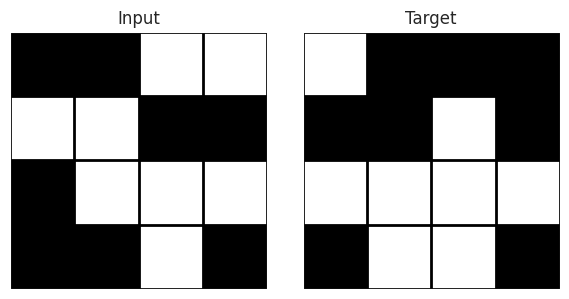

In [4]:
%matplotlib inline
sample_inputs, sample_targets = next(iter(trainloader))
sample_input = sample_inputs[0,:].reshape(grid_size, grid_size)
sample_target = sample_targets[0,:].reshape(grid_size, grid_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot the input
ax1.imshow(sample_input.flip(0), cmap='gray')
for i in range(grid_size+1):
    ax1.axhline(i-0.5, color='black', linewidth=2,)
    ax1.axvline(i-0.5, color='black', linewidth=2)
ax1.set_xlim(-0.5, grid_size-0.5)
ax1.set_ylim(-0.5, grid_size-0.5)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Input')

# Plot the target
ax2.imshow(sample_target.flip(0), cmap='gray')
for i in range(grid_size+1):
    ax2.axhline(i-0.5, color='black', linewidth=2)
    ax2.axvline(i-0.5, color='black', linewidth=2)
ax2.set_xlim(-0.5, grid_size-0.5)
ax2.set_ylim(-0.5, grid_size-0.5)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Target')

plt.tight_layout()
print(f"Input: {sample_inputs[0].tolist()}")
print(f"Target: {sample_targets[0].tolist()}")

### Loss Function

Next we define the loss function. First, for all internal ticks of the CTM, we calculate the cross-entropy loss for all positions along the output sequence. Then, as with the other experiments, we only use the loss at two specific internal ticks: where the loss is the lowest and where the model is most certain. We use advanced indexing into the losses tensor to extract these losses, and then average them.

In [ ]:
def parity_loss(predictions, certainties, targets, use_most_certain=True):
    """
    Computes the parity loss.

    Predictions are of shape: (B, parity_sequence_length, class, internal_ticks),
        where classes are in [0,1,2,3,4] for [Up, Down, Left, Right, Wait]
    Certainties are of shape: (B, 2, internal_ticks), 
        where the inside dimension (2) is [normalised_entropy, 1-normalised_entropy]
    Targets are of shape: [B, parity_sequence_length]

    use_most_certain will select either the most certain point or the final point. For baselines,
        the final point proved the only usable option. 
    """

    # Losses are of shape [B, parity_sequence_length, internal_ticks]
    losses = nn.CrossEntropyLoss(reduction='none')(predictions.flatten(0,1), torch.repeat_interleave(targets.unsqueeze(-1), predictions.size(-1), -1).flatten(0,1).long()).reshape(predictions[:,:,0].shape)

    # Average the loss over the parity sequence dimension
    losses = losses.mean(1)

    loss_index_1 = losses.argmin(dim=1)
    loss_index_2 = certainties[:,1].argmax(-1)
    if not use_most_certain:
        loss_index_2[:] = -1
    
    batch_indexer = torch.arange(predictions.size(0), device=predictions.device)
    loss_minimum_ce = losses[batch_indexer, loss_index_1].mean()
    loss_selected = losses[batch_indexer, loss_index_2].mean()

    loss = (loss_minimum_ce + loss_selected)/2
    return loss, loss_index_2

### Training

We define some helper functions for making the progress bar look pretty, and to display the training curves.

In [6]:
def make_pbar_desc(train_loss, train_accuracy, test_loss, test_accuracy, lr, where_most_certain):
    """A helper function to create a description for the tqdm progress bar"""
    pbar_desc = f'Train Loss={train_loss:0.3f}. Train Acc={train_accuracy:0.3f}. Test Loss={test_loss:0.3f}. Test Acc={test_accuracy:0.3f}. LR={lr:0.6f}.'
    pbar_desc += f' Where_certain={where_most_certain.float().mean().item():0.2f}+-{where_most_certain.float().std().item():0.2f} ({where_most_certain.min().item():d}<->{where_most_certain.max().item():d}).'
    return pbar_desc

In [7]:
def update_training_curve_plot(fig, ax1, ax2, train_losses, test_losses, train_accuracies, test_accuracies, steps):
    clear_output(wait=True)
    
    # Plot loss
    ax1.clear()
    ax1.plot(range(len(train_losses)), train_losses, 'b-', alpha=0.7, label=f'Train Loss: {train_losses[-1]:.3f}')
    ax1.plot(steps, test_losses, 'r-', marker='o', label=f'Test Loss: {test_losses[-1]:.3f}')
    ax1.set_title('Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.clear()
    ax2.plot(range(len(train_accuracies)), train_accuracies, 'b-', alpha=0.7, label=f'Train Accuracy: {train_accuracies[-1]:.3f}')
    ax2.plot(steps, test_accuracies, 'r-', marker='o', label=f'Test Accuracy: {test_accuracies[-1]:.3f}')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    display(fig)

We then write the function to train the CTM.

In [21]:
def train(model, trainloader, testloader, device='cpu', training_iterations=10000, test_every=1000, lr=1e-4, log_dir='./logs'):

    os.makedirs(log_dir, exist_ok=True)
    
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    iterator = iter(trainloader)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    steps = []
    
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    with tqdm(total=training_iterations) as pbar:
        for stepi in range(training_iterations):

            try:
                inputs, targets = next(iterator)
            except StopIteration:
                iterator = iter(trainloader)
                inputs, targets = next(iterator)
    
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            predictions_raw, certainties, _ = model(inputs)

            # Reshape: (B, SeqLength, C, T)
            predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 2, predictions_raw.size(-1))
            
            # Compute loss
            train_loss, where_most_certain = parity_loss(predictions, certainties, targets, use_most_certain=True)
            train_accuracy = (predictions.argmax(2)[torch.arange(predictions.size(0), device=predictions.device), :, where_most_certain] == targets).float().mean().item()

            train_losses.append(train_loss.item())
            train_accuracies.append(train_accuracy)

            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if stepi % test_every == 0 or stepi == 0:
                model.eval()
                with torch.no_grad():
                    all_test_predictions = []
                    all_test_targets = []
                    all_test_where_most_certain = []
                    all_test_losses = []

                    for inputs, targets in testloader:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        
                        predictions_raw, certainties, where_most_certain = model(inputs)
                        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 2, predictions_raw.size(-1))
                        
                        test_loss, where_most_certain = parity_loss(predictions, certainties, targets, use_most_certain=True)
                        all_test_losses.append(test_loss.item())
                        all_test_predictions.append(predictions)
                        all_test_targets.append(targets)
                        all_test_where_most_certain.append(where_most_certain)

                    all_test_predictions = torch.cat(all_test_predictions, dim=0)
                    all_test_targets = torch.cat(all_test_targets, dim=0)
                    all_test_where_most_certain = torch.cat(all_test_where_most_certain, dim=0)

                    test_accuracy = (all_test_predictions.argmax(2)[torch.arange(all_test_predictions.size(0), device=predictions.device), :, all_test_where_most_certain] == all_test_targets).float().mean().item()
                    test_loss = sum(all_test_losses) / len(all_test_losses)

                    test_losses.append(test_loss)
                    test_accuracies.append(test_accuracy)
                    steps.append(stepi)

                    create_maze_gif_visualization(model, testloader, device, log_dir)

                model.train()

                update_training_curve_plot(fig, ax1, ax2, train_losses, test_losses, train_accuracies, test_accuracies, steps)

            pbar_desc = make_pbar_desc(train_loss=train_loss.item(), train_accuracy=train_accuracy, test_loss=test_loss, test_accuracy=test_accuracy, lr=optimizer.param_groups[-1]["lr"], where_most_certain=where_most_certain)
            pbar.set_description(pbar_desc)
            pbar.update(1)

    plt.ioff()
    plt.close(fig)
    return model

def create_maze_gif_visualization(model, testloader, device, log_dir):
    model.eval()
    with torch.no_grad():
        inputs_viz, targets_viz = next(iter(testloader))
        inputs_viz = inputs_viz.to(device)
        targets_viz = targets_viz.to(device)

        predictions_raw, certainties, _, pre_activations, post_activations, attention = model(inputs_viz, track=True)
        
        # Reshape predictions
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 2, predictions_raw.size(-1))
        
        attention = reshape_attention_weights(attention)
        inputs = reshape_inputs(inputs_viz, 50, grid_size=grid_size)

        # Generate the parity GIF
        make_parity_gif(
            predictions.detach().cpu().numpy(),
            certainties.detach().cpu().numpy(),
            targets_viz.detach().cpu().numpy(),
            pre_activations,
            post_activations,
            attention,
            inputs,
            f'{log_dir}/prediction.gif',
        )
        
        predictions_raw, certainties, _ = model(inputs_viz)
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 2, predictions_raw.size(-1))


### Initialzing the CTM 

Next we initialize the CTM. There are three important arguments to highlight for this task, which differ from, for example, the image classification task.

- `backbone_type = 'parity_backbone'`: the backbone type `'parity_backbone'`, which is defined in the CTM repo, is a learned embedding layer which embeds the binary values in the input sequence.
- `positional_embedding_type = 'custom-rotational-1d'`: a positional embedding for each position in the parity sequence. These positional embeddings are added to the embedding vectors (produced by the backbone) during the forward pass.
- `prediction_reshaper = [parity_sequence_length, 2]`: the CTM has an optional argument `prediction_reshaper`. This is required when the output of the model is a sequence. For instance, it is required here where the output is a sequence of parities, or in the maze task where the output is a sequence of actions. This prediction reshaper is used in each internal tick of the CTM when the certainty of the models output is computed. Generally, the prediction reshaper should be like `[SEQUENCE_LENGTH, NUM_CLASS]`.

In [22]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model = CTM(
    iterations = 50,
    d_model = 256,
    d_input = 32,
    heads = 8,
    n_synch_out = 256,
    n_synch_action = 256,
    synapse_depth = 8,
    memory_length = 25,
    deep_nlms = True,
    memory_hidden_dims = 16,
    backbone_type = 'parity_backbone',
    out_dims = parity_sequence_length * 2,
    prediction_reshaper = [parity_sequence_length, 2],
    dropout = 0.0,
    do_layernorm_nlm = False,
    positional_embedding_type = 'custom-rotational-1d'
).to(device)

# Initialize model parameters with dummy forward pass
sample_batch = next(iter(trainloader))
dummy_input = sample_batch[0][:1].to(device)
with torch.no_grad():
    _ = model(dummy_input)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Using neuron select type: random-pairing
Synch representation size action: 256
Synch representation size out: 256
Model parameters: 652,106


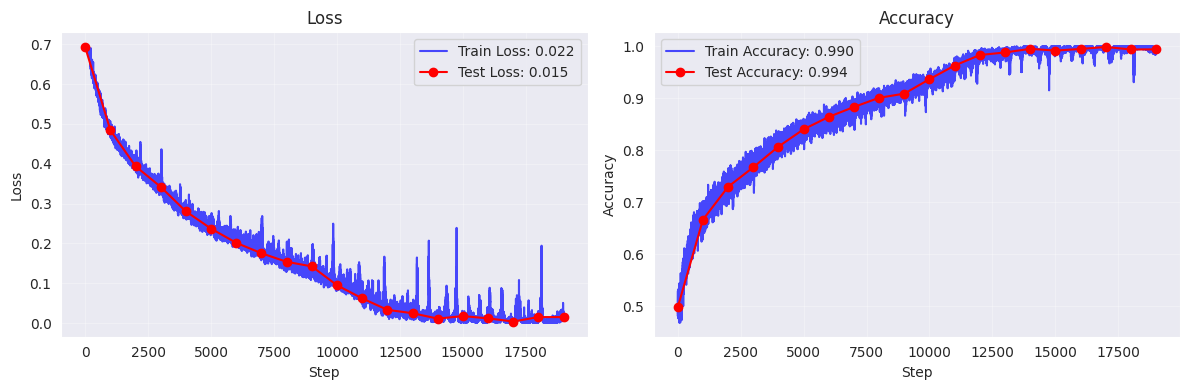

Train Loss=0.007. Train Acc=0.997. Test Loss=0.015. Test Acc=0.994. LR=0.000100. Where_certain=43.95+-3.85 (33<->49).: 100%|██████████| 20000/20000 [1:55:52<00:00,  2.88it/s]  


In [23]:
model = train(model=model, trainloader=trainloader, testloader=testloader, device=device, training_iterations=20000, lr=1e-4, log_dir='./parity_logs')

Visualise a gif of a solution

""

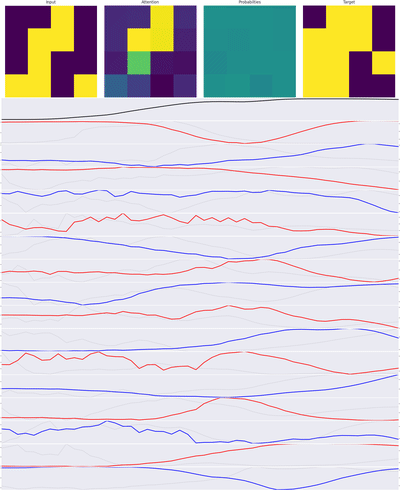

In [24]:
reader = imageio.get_reader("parity_logs/prediction.gif")
frames = [reader.get_data(i) for i in range(min(len(reader), 100))]
mediapy.show_video(frames, width=400, codec="gif")